In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0374

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - loss: 0.0286
Average validation loss: 0.6760725378990173
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - loss: 0.0286 - val_loss: 0.6761
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step - loss: 0.0200 - val_loss: 0.6761
Average validation loss: 0.6363370418548584
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 540ms/step - loss: 0.0200 - val_loss: 0.6562
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 531ms/step - loss: 0.0151 - val_loss: 0.6562
Average validation loss: 0.5035785436630249
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 542ms/step - loss: 0.0151 - val_loss: 0.6053
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segfo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 790ms/step - loss: 1.2697e-04
Average validation loss: 0.2922283560037613
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 802ms/step - loss: 1.2697e-04 - val_loss: 0.2922
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 792ms/step - loss: 1.2017e-04 - val_loss: 0.2922
Average validation loss: 0.10896947234869003
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 805ms/step - loss: 1.2017e-04 - val_loss: 0.2006
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 791ms/step - loss: 1.1447e-04 - val_loss: 0.2006
Average validation loss: 0.1358901970088482
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 803ms/step - loss: 1.1447e-04 - val_loss: 0.1790
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 785ms/step - loss: 1.0841e-04 - val_loss: 0.1790
Average

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 840ms/step - loss: 3.9350e-05
Average validation loss: 0.035440606685976185
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 848ms/step - loss: 3.9350e-05 - val_loss: 0.0354
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 824ms/step - loss: 3.5763e-05 - val_loss: 0.0354
Average validation loss: 0.02906745175520579
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 835ms/step - loss: 3.5763e-05 - val_loss: 0.0323
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 847ms/step - loss: 3.2482e-05 - val_loss: 0.0323
Average validation loss: 0.05095671862363815
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 858ms/step - loss: 3.2482e-05 - val_loss: 0.0385
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 839ms/step - loss: 2.9768e-05 - val_l

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 898ms/step - loss: 8.7860e-06
Average validation loss: 0.017899745609611273
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 909ms/step - loss: 8.7860e-06 - val_loss: 0.0179
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 833ms/step - loss: 7.4509e-06 - val_loss: 0.0179
Average validation loss: 0.013904328923672438
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 844ms/step - loss: 7.4509e-06 - val_loss: 0.0159
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 823ms/step - loss: 6.5087e-06 - val_loss: 0.0159
Average validation loss: 0.012942264147568494
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 835ms/step - loss: 6.5087e-06 - val_loss: 0.0149
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 823ms/step - loss: 1.8724e-05
Average validation loss: 0.02919561741873622
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 832ms/step - loss: 1.8724e-05 - val_loss: 0.0292
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 805ms/step - loss: 1.2921e-05 - val_loss: 0.0292
Average validation loss: 0.010739849880337715
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 816ms/step - loss: 1.2921e-05 - val_loss: 0.0200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 792ms/step - loss: 1.2230e-05 - val_loss: 0.0200
Average validation loss: 0.018256044201552867
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 802ms/step - loss: 1.2230e-05 - val_loss: 0.0194
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 800ms/step - loss: 1.0460e-05 - val_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 800ms/step - loss: 2.8812e-05
Average validation loss: 0.013666724786162376
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 810ms/step - loss: 2.8812e-05 - val_loss: 0.0137
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 790ms/step - loss: 1.8094e-05 - val_loss: 0.0137
Average validation loss: 0.010094606395189961
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 800ms/step - loss: 1.8094e-05 - val_loss: 0.0119
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 793ms/step - loss: 1.3567e-05 - val_loss: 0.0119
Average validation loss: 0.004998329735826701
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 802ms/step - loss: 1.3567e-05 - val_loss: 0.0096
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 798ms/step - loss: 1.4353e-05
Average validation loss: 0.016907940385863185
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 809ms/step - loss: 1.4353e-05 - val_loss: 0.0169
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 794ms/step - loss: 1.2877e-05 - val_loss: 0.0169
Average validation loss: 0.025909323687665166
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 804ms/step - loss: 1.2877e-05 - val_loss: 0.0214
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 804ms/step - loss: 1.1661e-05 - val_loss: 0.0214
Average validation loss: 0.01716725042788312
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 814ms/step - loss: 1.1661e-05 - val_loss: 0.0200
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 789ms/step - loss: 1.0557e-05 - val_loss: 0.0200
Average validation loss: 0.021121708065038547
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 798ms/step - loss: 1.0557e-05 - val_loss: 0.0203
Epoch 5/10

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 804ms/step - loss: 9.8879e-06
Average validation loss: 0.008497849941098442
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 816ms/step - loss: 9.8879e-06 - val_loss: 0.0085
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 805ms/step - loss: 6.9342e-06 - val_loss: 0.0085
Average validation loss: 0.006520457953835527
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 817ms/step - loss: 6.9342e-06 - val_loss: 0.0075
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 796ms/step - loss: 5.1556e-06 - val_loss: 0.0075
Average validation loss: 0.0059490692025671406
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 808ms/step - loss: 5.1556e-06 - val_loss: 0.0070
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 806ms/step - loss: 5.0290e-06
Average validation loss: 0.009185817325487733
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 818ms/step - loss: 5.0290e-06 - val_loss: 0.0092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 819ms/step - loss: 3.4670e-06 - val_loss: 0.0092
Average validation loss: 0.008902125526219606
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 831ms/step - loss: 3.4670e-06 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 805ms/step - loss: 3.1974e-06 - val_loss: 0.0090
Average validation loss: 0.008946005238353141
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 816ms/step - loss: 3.1974e-06 - val_loss: 0.0090
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 183s 813ms/step - loss: 2.9406e-06 - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 799ms/step - loss: 2.2354e-06
Average validation loss: 0.009938210336258635
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 810ms/step - loss: 2.2354e-06 - val_loss: 0.0099
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 799ms/step - loss: 1.8320e-06 - val_loss: 0.0099
Average validation loss: 0.00942163735453505
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 810ms/step - loss: 1.8320e-06 - val_loss: 0.0097
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 794ms/step - loss: 1.4924e-06 - val_loss: 0.0097
Average validation loss: 0.009795668243896216
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 805ms/step - loss: 1.4924e-06 - val_loss: 0.0097
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 206s 797ms/step - loss: 1.3681e-06 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 796ms/step - loss: 1.0888e-06
Average validation loss: 0.012734671579285836
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 807ms/step - loss: 1.0888e-06 - val_loss: 0.0127
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 794ms/step - loss: 1.0933e-06 - val_loss: 0.0127
Average validation loss: 0.01813889524136256
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 805ms/step - loss: 1.0933e-06 - val_loss: 0.0154
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 175s 814ms/step - loss: 9.2369e-07 - val_loss: 0.0154
Average validation loss: 0.011976926118626984
72/72 ━━━━━━━━━━━━━━━━━━━━ 175s 825ms/step - loss: 9.2369e-07 - val_loss: 0.0143
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 233s 804ms/step - loss: 1.0988e-06 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 73s 911ms/step - loss: 2.1305e-06
Average validation loss: 0.008641377330059185
80/80 ━━━━━━━━━━━━━━━━━━━━ 74s 922ms/step - loss: 2.1305e-06 - val_loss: 0.0086
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 138s 802ms/step - loss: 1.6540e-06 - val_loss: 0.0086
Average validation loss: 0.006966478974209167
80/80 ━━━━━━━━━━━━━━━━━━━━ 139s 813ms/step - loss: 1.6540e-06 - val_loss: 0.0078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 205s 822ms/step - loss: 1.3765e-06 - val_loss: 0.0078
Average validation loss: 0.006938544812146574
80/80 ━━━━━━━━━━━━━━━━━━━━ 206s 833ms/step - loss: 1.3765e-06 - val_loss: 0.0075
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weig

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 793ms/step - loss: 2.7633e-06
Average validation loss: 0.015055135969305411
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 804ms/step - loss: 2.7633e-06 - val_loss: 0.0151
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 789ms/step - loss: 2.1931e-06 - val_loss: 0.0151
Average validation loss: 0.014222674178502833
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 800ms/step - loss: 2.1931e-06 - val_loss: 0.0146
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 230s 790ms/step - loss: 1.7682e-06 - val_loss: 0.0146
Average validation loss: 0.014384835745052746
96/96 ━━━━━━━━━━━━━━━━━━━━ 231s 802ms/step - loss: 1.7682e-06 - val_loss: 0.0146
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 306s 786ms/step - loss: 1.4940e-0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 798ms/step - loss: 4.7441e-06
Average validation loss: 0.008820479339919984
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 809ms/step - loss: 4.7441e-06 - val_loss: 0.0088
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 808ms/step - loss: 3.6840e-06 - val_loss: 0.0088
Average validation loss: 0.009950382076203823
120/120 ━━━━━━━━━━━━━━━━━━━━ 195s 818ms/step - loss: 3.6840e-06 - val_loss: 0.0094
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 793ms/step - loss: 2.8665e-06 - val_loss: 0.0094
Average validation loss: 0.010527726676082238
120/120 ━━━━━━━━━━━━━━━━━━━━ 292s 804ms/step - loss: 2.8665e-06 - val_loss: 0.0098
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 388s 805ms/step - loss: 2.3794e-06 - val_loss: 0.0098
Average validation loss: 0.011112605753199507
120/120 ━━━━━━━━━━━━━━━━━━━━ 390s 816ms/step - loss: 2.3794e-06 - val_l

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 793ms/step - loss: 5.1940e-06
Average validation loss: 0.009626435500750732
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 804ms/step - loss: 5.1940e-06 - val_loss: 0.0096
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 797ms/step - loss: 3.7229e-06 - val_loss: 0.0096
Average validation loss: 0.009107202666604685
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 808ms/step - loss: 3.7229e-06 - val_loss: 0.0094
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 346s 793ms/step - loss: 2.9807e-06 - val_loss: 0.0094
Average validation loss: 0.008083359584108822
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 804ms/step - loss: 2.9807e-06 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetectio

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 797ms/step - loss: 2.9133e-06
Average validation loss: 0.014647079457063228
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 807ms/step - loss: 2.9133e-06 - val_loss: 0.0146
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 256s 795ms/step - loss: 2.2021e-06 - val_loss: 0.0146
Average validation loss: 0.009008935946621933
160/160 ━━━━━━━━━━━━━━━━━━━━ 258s 806ms/step - loss: 2.2021e-06 - val_loss: 0.0118
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 385s 792ms/step - loss: 1.7600e-06 - val_loss: 0.0118
Average validation loss: 0.0093767226615455
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 803ms/step - loss: 1.7600e-06 - val_loss: 0.0110
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 513s 792ms/step - l

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 808ms/step - loss: 2.3379e-06
Average validation loss: 0.008219307221006602
200/200 ━━━━━━━━━━━━━━━━━━━━ 164s 819ms/step - loss: 2.3379e-06 - val_loss: 0.0082
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 324s 799ms/step - loss: 1.7229e-06 - val_loss: 0.0082
Average validation loss: 0.007774090534367133
200/200 ━━━━━━━━━━━━━━━━━━━━ 326s 810ms/step - loss: 1.7229e-06 - val_loss: 0.0080
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 485s 797ms/step - loss: 1.4136e-06 - val_loss: 0.0080
Average validation loss: 0.008799152992578456
200/200 ━━━━━━━━━━━━━━━━━━━━ 487s 807ms/step - loss: 1.4136e-06 - val_loss: 0.0083
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 647s 796ms/step -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 796ms/step - loss: 1.6284e-06
Average validation loss: 0.01423721765834974
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 807ms/step - loss: 1.6284e-06 - val_loss: 0.0142
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 385s 797ms/step - loss: 1.3074e-06 - val_loss: 0.0142
Average validation loss: 0.008886447963353325
240/240 ━━━━━━━━━━━━━━━━━━━━ 388s 808ms/step - loss: 1.3074e-06 - val_loss: 0.0116
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 579s 797ms/step - loss: 1.2187e-06 - val_loss: 0.0116
Average validation loss: 0.0077641610063437835
240/240 ━━━━━━━━━━━━━━━━━━━━ 581s 808ms/step - loss: 1.2187e-06 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\RipplesDetectio

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.18207990542054175, 0.07608339925296605, 0.029187911728707452, 0.013856367009575479, 0.010663099771831186, 0.011091566980758217, 0.010601943089044653, 0.007099619831472713, 0.0071473749826795295, 0.008891747358611611, 0.007846726116711378, 0.007839943818631581, 0.00833191477424407, 0.007819097369948092, 0.010285027436151622, 0.007809481112068397, 0.007449141807189859, 0.007341731410558963]
std_val_losses =  [0.16045098575247638, 0.06449527016861366, 0.016417023059083134, 0.007087191962814842, 0.005233330179052113, 0.008979970483044957, 0.00656156853810983, 0.0025431503552590497, 0.0024682654543444716, 0.006786003670415227, 0.003459436277355069, 0.0021642750303093104, 0.00327773355734783, 0.0015756325068289683, 0.004203044820833469, 0.0026554867146753067, 0.0015299222421676826, 0.0016819640220718292]


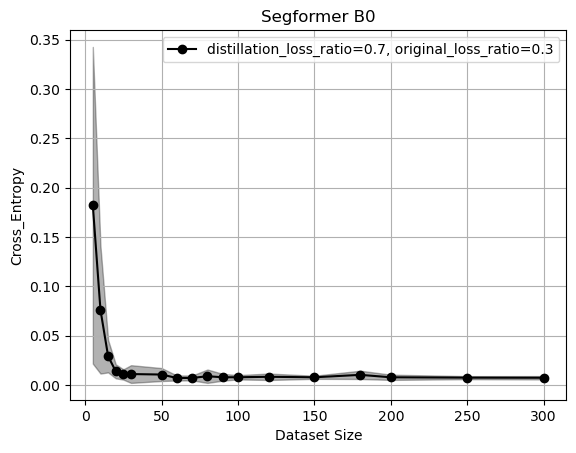

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()